In [1]:
from ioMicro import *

In [ ]:
fl =r'\\192.168.0.100\bbfish100\DCBBL1_4week_6_2_2023\P2_Sox11_Sox2_Dcx__set2\Conv_zscan__010.zarr'
im = read_im(fl)
import napari
napari.view_image(im);

### Save psf

In [4]:
psfs = []

In [ ]:
master_folder = r'\\192.168.0.100\bbfish100\DCBBL1_4week_6_2_2023\P2_Sox11_Sox2_Dcx__set2'

for ifov in tqdm([11,12,13,14,15,16,17,18]):
    im = read_im(master_folder+r'\Conv_zscan__'+str(ifov).zfill(3)+'.zarr')
    im_ = np.array(im[0][1:,500:2500,500:2500],dtype=np.float32)
    psf = get_psf(im_,th=1000,th_cor = 0.75,delta=3,delta_fit = 7,sxyzP = [15,60,60])
    psfs.append(psf)
#napari.view_image(im)
psff = np.mean([psf for psf in psfs if psf is not None],axis=0)
psff_ = np.array([p-np.median(p) for p in psff])
from scipy.ndimage import median_filter
psff_med = median_filter(psff_, size=15)
psfff = (psff_-psff_med)[5:-5,5:-5,5:-5][:-1,:-1,:-1]
psfff[psfff<0]=0
psfff = psfff/np.max(psfff)
np.save('psf_750_Scope3_final.npy',psfff)

In [16]:
if False:
    imd = apply_deconv(im_[:,750:-750,750:-750],
        psf=psf,
        plt_val=True,
        parameters={'method': 'wiener', 'beta': 0.0001, 'niter': 50},
        gpu=False,
        force=True,
        pad=None)

In [22]:
import shutil
save_folder = os.path.dirname(master_folder)+os.sep+'MERFISH_Analysis'
if not os.path.exists(save_folder): os.makedirs(save_folder)
shutil.copy2(os.path.abspath('psf_750_Scope3_final.npy'),save_folder+os.sep+'psf_750_Scope3_final.npy')

'\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\MERFISH_Analysis\\psf_750_Scope3_final.npy'

### Compute flat field

In [24]:
#np.load(r'\\192.168.0.100\bbfish100\DCBBL1_1year1wkNJ_ASO_SAL_4_18_2023\MERFISH_Analysis\med_col0.npz')['im'].shape

(300, 300)

In [2]:
data_fld = r'\\192.168.0.100\bbfish100\DCBBL1_4week_6_2_2023\P2_Sox11_Sox2_Dcx__set1'
save_folder = os.path.dirname(data_fld)+os.sep+'MERFISH_Analysis'
if not os.path.exists(save_folder): os.makedirs(save_folder)

In [3]:
compute_flat_field_raw(data_fld=data_fld,
    save_folder=save_folder,
    ncols=4)

100%|████████████████████████████████████████████████████████████████████████████████| 698/698 [06:43<00:00,  1.73it/s]


### Compute mosaics

In [1]:
import time
import numpy as np,os,sys,glob
import matplotlib.pylab as plt
from ioMicro import *

data_flds = glob.glob(r'\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\H0__*')
for data_fld in data_flds:
    resc = 4
    icol = -1
    save_folder= os.path.dirname(data_fld)+os.sep+'mosaics'
    if not os.path.exists(save_folder): os.makedirs(save_folder)
    if os.path.isdir(data_fld):
        
        fl_save = save_folder+os.sep+os.path.basename(data_fld)+'_col'+str(icol)+'.png'
        print(fl_save)
        if not os.path.exists(fl_save):
            fls_ = np.sort(glob.glob(data_fld+r'\*.zarr'))
            ims,xs_um,ys_um=[],[],[]
            from tqdm.notebook import tqdm

            for fl in tqdm(fls_[:]):
                im,x,y = read_im(fl,return_pos=True)
                ims.append(np.array(im[icol][15,::resc,::resc],dtype=np.float32))
                xs_um.append(x)
                ys_um.append(y)

            im_big,xs,ys = compose_mosaic([im.T[::-1,::1] for im in ims],xs_um,ys_um,ims_c=None,
                                          um_per_pix=0.1083333*resc,
                                          rot = 0,return_coords= True)


            resc_ = 3
            data_fld = os.path.dirname(fls_[0])
            fig = plt.figure(figsize=(30,30))
            im__ = im_big[::resc_,::resc_]
            vmax = np.percentile(im__[im__>0],99.)
            plt.imshow(im_big.T[::resc_,::resc_],vmin=0,vmax=vmax,cmap='gray')


            fig.savefig(fl_save)
            for x_,y_,fl_ in zip(xs,ys,fls_):
                ifov = fl_.split('_')[-1].split('.')[0]
                plt.text(x_/resc_,y_/resc_,ifov,color='r')
            plt.xticks([])
            plt.yticks([])
            fl_save = fl_save.replace('.png','_annot.png')
            print(fl_save)
            fig.savefig(fl_save)
            plt.close('all')
#     else:
#         time.sleep(300)

\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set1_col-1.png


  0%|          | 0/67 [00:00<?, ?it/s]

\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set1_col-1_annot.png
\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set2_col-1.png


  0%|          | 0/27 [00:00<?, ?it/s]

\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set2_col-1_annot.png
\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set3_col-1.png


  0%|          | 0/74 [00:00<?, ?it/s]

\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set3_col-1_annot.png
\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set4_col-1.png


  0%|          | 0/58 [00:00<?, ?it/s]

\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set4_col-1_annot.png
\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set5_col-1.png


  0%|          | 0/91 [00:00<?, ?it/s]

\\192.168.0.21\bbfishdc21\HttHuman_Snonia__06_12_2023\mosaics\H0__set5_col-1_annot.png


### Compute one fov

In [1]:
from ioMicro import *
from workerScope3New import *
#get_files(['_set1',30])

main_f(['_set1',30],redo_fits = False,redo_drift=False,redo_decoding=False,try_mode=False)

Computing fitting on: Conv_zscan__030.zarr
19 ['\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H0__set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\P1__Igfbp_Aldh1l1_Ptbp1__set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H1_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\P2_Sox11_Sox2_Dcx__set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H2_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H3_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H4_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H5_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H6_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H7_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H8_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H9_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4week_6_2_2023\\H10_MER_set1', '\\\\192.168.0.100\\bbfish100\\DCBBL1_4we

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [48:05<00:00, 151.87s/it]


Computing drift on: Conv_zscan__030.zarr
Computing drift...


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [04:25<00:00, 13.96s/it]


Not completed


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [05:34<00:00, 111.34s/it]


Unfolded molecules: 132.8494153022766
Computed the decoding: 160.5524594783783


100%|███████████████████████████████████████████████████████████████████| 16172708/16172708 [02:51<00:00, 94427.83it/s]


Computed best unique assigment: 174.56177759170532


['_set1', 30]

In [6]:
from ioMicro import *

save_folder = r'\\192.168.0.100\bbfish100\DCBBL1_4week_6_2_2023\MERFISH_Analysis'
fov,set_ = 'Conv_zscan__030','_set1'
dec = decoder_simple(save_folder,fov,set_)
dec.load_decoded()

Loaded decoded: -4.9082701206207275


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  5.22it/s]


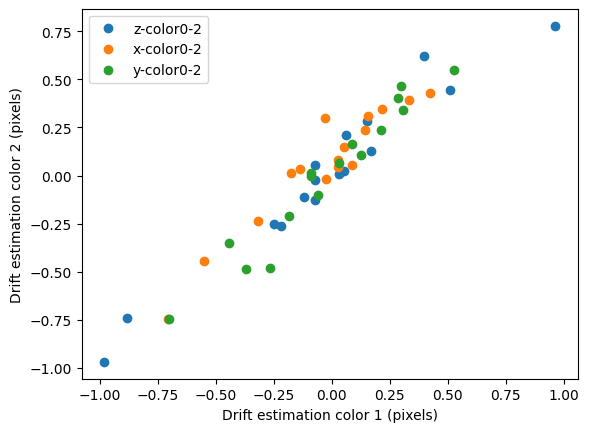

In [9]:
apply_fine_drift(dec,plt_val=True)

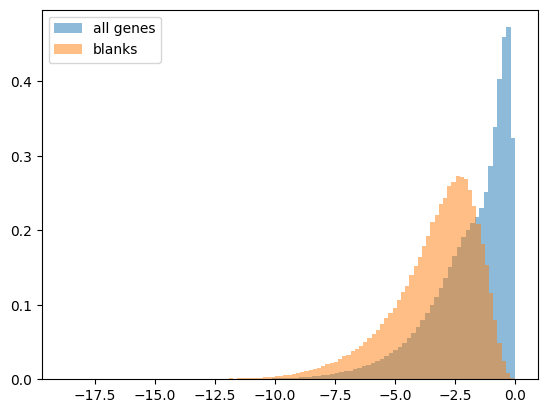

In [11]:
dec.ncols=3
scoresRef = get_score_per_color(dec)
get_score_withRef(dec,scoresRef,plt_val=True,gene=None,iSs = None)
dec.th=-1.5
plot_statistics(dec)

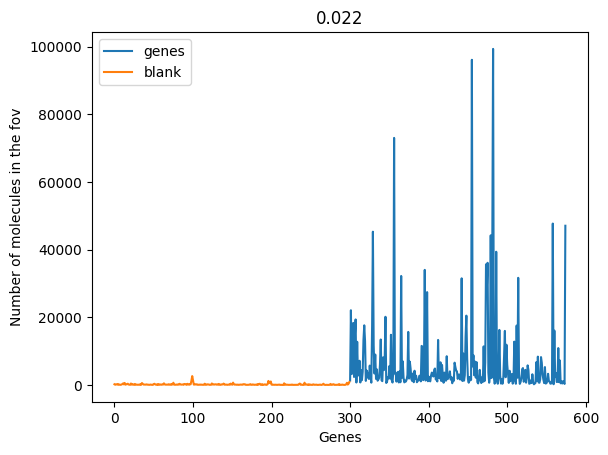

In [12]:
dec.th=-1.5
plot_statistics(dec)

In [31]:
viewer = plot_multigenes(dec,genes=['Vim'],colors=['r','g','b','m','c','y','w'],viewer = None,
                         smin=2,smax=10)

In [18]:
dec.gns_names[250:]

array(['blank0251', 'blank0252', 'blank0253', 'blank0254', 'blank0255',
       'blank0256', 'blank0257', 'blank0258', 'blank0259', 'blank0260',
       'blank0261', 'blank0262', 'blank0263', 'blank0264', 'blank0265',
       'blank0266', 'blank0267', 'blank0268', 'blank0269', 'blank0270',
       'blank0271', 'blank0272', 'blank0273', 'blank0274', 'blank0275',
       'blank0276', 'blank0277', 'blank0278', 'blank0279', 'blank0280',
       'blank0281', 'blank0282', 'blank0283', 'blank0284', 'blank0285',
       'blank0286', 'blank0287', 'blank0288', 'blank0289', 'blank0290',
       'blank0291', 'blank0292', 'blank0293', 'blank0294', 'blank0295',
       'blank0296', 'blank0297', 'blank0298', 'blank0299', 'blank0300',
       'Acer3', 'Actg1', 'Adcy2', 'Ahcyl2', 'Aldoc', 'Ascl1', 'Auts2',
       'Bhlhe22', 'Bmp2', 'Bsg', 'C1qa', 'Calb1', 'Cck', 'Cdh12', 'Cdk4',
       'Chrdl1', 'Cnr1', 'Csmd1', 'Cst3', 'Dgat2', 'Dlx1', 'Dsp',
       'Eif4a2', 'Emx2', 'Eomes', 'Fam107a', 'Flt1', 'Foxa2', 'Foxg1'

### Check progress

In [3]:
#save_folder =r'\\192.168.0.6\bbfishjoy4\CGBB_embryo_4_28_2023\MERFISH_Analysis3'
import os,glob,numpy as np
data_fld = r'\\192.168.0.100\bbfish100\DCBBL1_4week_6_2_2023\P2_Sox11_Sox2_Dcx__set1'
save_folder = os.path.dirname(data_fld)+os.sep+'MERFISH_Analysis'
fls = glob.glob(save_folder+os.sep+'decoded*')

In [4]:
len(fls)

504

In [7]:
fov_fls = glob.glob(save_folder+os.sep+'*fov*')
fov_all = [(fl_,os.path.basename(fl).split('__')[-1].split('.')[0]) for fl in fov_fls for fl_ in np.load(fl)]

print(len(fov_all))

fov_completed = [tuple(os.path.basename(fl).replace('decoded_','').replace('.npz','').replace('--','.zarr--').split('--'))for fl in fls]
#[e for e in fov_all if e not in fov_completed]

813


In [15]:
times = [os.path.getctime(fl) for fl in fls]
diffT = np.diff(np.sort(times)).astype(int)
np.median(diffT),np.mean(diffT[-50:])

(483.5, 881.32)

829.08

In [10]:
diffT

array([25353,   533,   146,     4,    93,  1036,  3370,   456,     0,
         166,   223,  1089,  3286,    79,   365,   219,   129,  3295,
         271,   585,   276,   295,  2234,   928,   841,   187,   490,
         952,  1112,  1780,   144,   668,   353,   902,  2561,   131,
         630,   123,   922,  2110,    13,  1430,   104,   139,  2419,
         111,  2044,    26,   339,   696,   280,  3123,   230,    83,
         122,   731,  1762])